# Sectoral Rotation Detection (India) — ML Pipeline

**Goal**: Detect and exploit sectoral rotation within Indian equities using
1) relative-strength features, 2) market regime detection (HMM), and 3) a supervised
learner to pick next-month outperforming sectors, with a simple top-N backtest.

**What you get**
- Automated data download for NIFTY sector indices from Yahoo Finance
- Feature engineering (monthly returns, relative momentum, volatility, beta, RSI, MACD, Sector/NIFTY ratio)
- Regime detection with Hidden Markov Models (HMM)
- Supervised model (XGBoost or GradientBoosting as fallback) to predict next-month outperformance vs NIFTY 50
- Rotation strategy backtest (long top-N sectors monthly), with metrics (CAGR, Sharpe, MaxDD) and charts
- Clean, modular code for you to extend (e.g., add macro factors, custom constraints)

> **Data note**: Yahoo sector index tickers used here (tested):
> - Benchmark: **^NSEI** (NIFTY 50)
> - **^NSEBANK** (Bank), **^CNXIT** (IT), **^CNXAUTO** (Auto), **^CNXPHARMA** (Pharma), **^CNXFMCG** (FMCG),
>   **^CNXMETAL** (Metal), **^CNXENERGY** (Energy), **^CNXREALTY** (Realty), **^CNXMEDIA** (Media), **^CNXINFRA** (Infra)
>
> These symbols are discoverable on Yahoo Finance and have historical downloads.

**Run order**: top-to-bottom. If a library is missing, `pip install` inside the notebook.

*Last generated:* 2025-09-15T13:56:50


In [1]:
%matplotlib inline
VERBOSE = True
def log(msg):
    if VERBOSE:
        print(f"[LOG] {msg}")


In [2]:
# === 0) Setup & Imports ===
import os, sys, math, warnings, json
from dataclasses import dataclass
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

try:
    import yfinance as yf
except Exception as e:
    print("If yfinance is missing: pip install yfinance --quiet")

try:
    from hmmlearn.hmm import GaussianHMM
    HMM_AVAILABLE = True
except Exception as e:
    print("If hmmlearn is missing: pip install hmmlearn --quiet")
    HMM_AVAILABLE = False

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    XGB_AVAILABLE = False

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

TZ = 'Asia/Kolkata'  # IST
START = '2010-01-01'
END = datetime.now().strftime('%Y-%m-%d')


KeyboardInterrupt: 

In [ ]:
# === 1) Universe Definition (Yahoo Finance tickers) ===
BENCH = '^NSEI'  # NIFTY 50
SECTORS = {
    'BANK': '^NSEBANK',
    'IT': '^CNXIT',
    'AUTO': '^CNXAUTO',
    'PHARMA': '^CNXPHARMA',
    'FMCG': '^CNXFMCG',
    'METAL': '^CNXMETAL',
    'ENERGY': '^CNXENERGY',
    'REALTY': '^CNXREALTY',
    'MEDIA': '^CNXMEDIA',
    'INFRA': '^CNXINFRA',
}

print(f"Benchmark: {BENCH}\nSectors: {SECTORS}")


Benchmark: ^NSEI
Sectors: {'BANK': '^NSEBANK', 'IT': '^CNXIT', 'AUTO': '^CNXAUTO', 'PHARMA': '^CNXPHARMA', 'FMCG': '^CNXFMCG', 'METAL': '^CNXMETAL', 'ENERGY': '^CNXENERGY', 'REALTY': '^CNXREALTY', 'MEDIA': '^CNXMEDIA', 'INFRA': '^CNXINFRA'}


In [ ]:
# === 2) Data Download (Daily) — Robust & Verbose ===
log('Starting downloads via yfinance...')
def download_prices(tickers, start=START, end=END, tz=TZ):
    df = yf.download(tickers, start=start, end=end, interval='1d', auto_adjust=True, threads=True, multi_level_index=False)['Close']
    if isinstance(df, pd.Series):
        df = df.to_frame()
    idx = pd.to_datetime(df.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    df.index = idx.tz_convert(tz)
    return df.sort_index()

bench_px = download_prices([BENCH])
if bench_px.shape[1] == 1:
    bench_px.columns = [BENCH]
sect_px = download_prices(list(SECTORS.values()))
log(f'Benchmark shape: {bench_px.shape}, Sectors shape: {sect_px.shape}')
log(f'Benchmark head:\n{bench_px.head()}')
log(f'Sectors head:\n{sect_px.head()}')
assert not bench_px.empty, 'Benchmark download returned empty. Check internet/ticker.'
assert not sect_px.empty, 'Sector download returned empty. Check internet/tickers.'


[LOG] Starting downloads via yfinance...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed

[LOG] Benchmark shape: (3855, 1), Sectors shape: (3870, 10)
[LOG] Benchmark head:
                                 ^NSEI
Date                                  
2010-01-04 05:30:00+05:30  5232.200195
2010-01-05 05:30:00+05:30  5277.899902
2010-01-06 05:30:00+05:30  5281.799805
2010-01-07 05:30:00+05:30  5263.100098
2010-01-08 05:30:00+05:30  5244.750000
[LOG] Sectors head:
Ticker                     ^CNXAUTO  ^CNXENERGY  ^CNXFMCG  ^CNXINFRA  \
Date                                                                   
2010-01-04 05:30:00+05:30       NaN         NaN       NaN        NaN   
2010-01-05 05:30:00+05:30       NaN         NaN       NaN        NaN   
2010-01-06 05:30:00+05:30       NaN         NaN       NaN        NaN   
2010-01-07 05:30:00+05:30       NaN         NaN       NaN        NaN   
2010-01-08 05:30:00+05:30       NaN         NaN       NaN        NaN   

Ticker                          ^CNXIT  ^CNXMEDIA  ^CNXMETAL  ^CNXPHARMA  \
Date                                        

In [ ]:
# === 3) Resample to Month-End and Compute Returns (Robust) ===
def to_monthly_last(px):
    m = px.resample('M').last()
    if isinstance(m, pd.Series):
        m = m.to_frame()
    try:
        m.index = m.index.tz_convert(TZ)
    except Exception:
        pass
    return m

bench_m = to_monthly_last(bench_px)
sect_m = to_monthly_last(sect_px)

# Align on common months to avoid sparse issues
common_idx = bench_m.index.intersection(sect_m.index)
bench_m = bench_m.loc[common_idx]
sect_m = sect_m.loc[common_idx]
log(f'Monthly aligned shapes — bench: {bench_m.shape}, sectors: {sect_m.shape}')

bench_ret = bench_m.pct_change()
sect_ret = sect_m.pct_change()
bench_ret_s = bench_ret.iloc[:, 0].rename('BenchRet')
rel_ret = sect_ret.sub(bench_ret_s, axis=0)
log('Computed monthly returns and relative returns.')


[LOG] Monthly aligned shapes — bench: (189, 1), sectors: (189, 10)
[LOG] Computed monthly returns and relative returns.


In [ ]:
# === 4) Feature Engineering (monthly) ===
def rsi(series, n=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/n, adjust=False).mean()
    roll_down = down.ewm(alpha=1/n, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def rolling_beta(y, x, win=12):
    cov = y.rolling(win).cov(x)
    var = x.rolling(win).var()
    return cov / (var + 1e-12)

def ensure_tz(series, tz):
    s = pd.to_datetime(series)
    # If naive -> localize; if aware -> convert
    return s.dt.tz_localize(tz) if s.dt.tz is None else s.dt.tz_convert(tz)

monthly_px = sect_m.copy()
monthly_px[BENCH] = bench_m[BENCH]

features = []
for sym in monthly_px.columns:
    px = monthly_px[sym]
    ret = px.pct_change()
    mom_3 = px.pct_change(3)
    mom_6 = px.pct_change(6)
    mom_12 = px.pct_change(12)
    vol_6 = ret.rolling(6).std()
    vol_12 = ret.rolling(12).std()
    rsi_14 = rsi(px, 14)
    macd_line, macd_sig, macd_hist = macd(px, 12, 26, 9)
    if sym != BENCH:
        ratio = (px / monthly_px[BENCH]).rename('RS')
        rs_mom_3 = ratio.pct_change(3)
        rs_mom_6 = ratio.pct_change(6)
        rs_mom_12 = ratio.pct_change(12)
        beta_12 = rolling_beta(ret, monthly_px[BENCH].pct_change(), 12)
    else:
        ratio = pd.Series(index=px.index, dtype=float)
        rs_mom_3 = rs_mom_6 = rs_mom_12 = beta_12 = pd.Series(index=px.index, dtype=float)

    df = pd.DataFrame({
        'Symbol': sym,
        'Price': px,
        'Ret1M': ret,
        'MOM_3': mom_3,
        'MOM_6': mom_6,
        'MOM_12': mom_12,
        'VOL_6': vol_6,
        'VOL_12': vol_12,
        'RSI_14': rsi_14,
        'MACD': macd_line,
        'MACD_SIG': macd_sig,
        'MACD_HIST': macd_hist,
        'RS': ratio,
        'RS_MOM_3': rs_mom_3,
        'RS_MOM_6': rs_mom_6,
        'RS_MOM_12': rs_mom_12,
        'BETA_12': beta_12,
    })
    features.append(df)

feat = pd.concat(features).reset_index().rename(columns={'index':'Date'})
feat['Date'] = ensure_tz(feat['Date'], TZ)
feat.head()
log(f'Feature frame built with shape: {feat.shape}')


[LOG] Feature frame built with shape: (2079, 18)


In [ ]:
# === 5) Regime Detection with HMM on Benchmark Returns ===
bench_df = pd.DataFrame({
    'Date': bench_m.index,
    'Bench': bench_m[BENCH].values,
})
bench_df['Ret1M'] = bench_df['Bench'].pct_change()
bench_df.dropna(inplace=True)

n_states = 3  # e.g., Bear(0), Sideways(1), Bull(2)
if HMM_AVAILABLE:
    hmm = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=42)
    X = bench_df[['Ret1M']].values
    hmm.fit(X)
    bench_df['Regime'] = hmm.predict(X)
else:
    # Fallback: simple quantile-based regimes
    q1, q2 = bench_df['Ret1M'].quantile([0.33, 0.66])
    bench_df['Regime'] = np.select(
        [bench_df['Ret1M']<=q1, bench_df['Ret1M']<=q2],
        [0,1],
        default=2
    )

bench_df.tail()
log(f'Regime counts: {bench_df["Regime"].value_counts().to_dict()}')


[LOG] Regime counts: {0: 93, 1: 92, 2: 3}


In [ ]:
# === 6) Supervised Dataset: Predict Sector Outperformance Next Month ===
# Label: 1 if sector's next-month return > benchmark next-month return, else 0.
sect_ret_m = sect_m.pct_change()
bench_ret_m = bench_m.pct_change().iloc[:,0].rename('BenchRet')

# Merge features with label & regime
df = feat.merge(bench_df[['Date','Regime']], on='Date', how='left')
df = df[df['Symbol'].isin(sect_m.columns)].copy()  # only sectors for prediction

# Next-month returns per symbol
nm = sect_ret_m.shift(-1)
nm_b = bench_ret_m.shift(-1)

def label_row(row):
    d = row['Date']
    sym = row['Symbol']
    try:
        r_sym = nm.loc[d, sym]
        r_ben = nm_b.loc[d]
        return int(r_sym > r_ben)
    except KeyError:
        return np.nan

df['Label'] = df.apply(label_row, axis=1)
df = df.dropna(subset=['Label']).copy()
df['Label'] = df['Label'].astype(int)
print(df[['Date','Symbol','Label']].tail())

FEATURE_COLS = [
    'MOM_3','MOM_6','MOM_12','VOL_6','VOL_12','RSI_14','MACD','MACD_SIG','MACD_HIST',
    'RS','RS_MOM_3','RS_MOM_6','RS_MOM_12','BETA_12','Regime'
]

X = df[FEATURE_COLS].fillna(0.0).values
y = df['Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if XGB_AVAILABLE:
    model = XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', random_state=42
    )
else:
    model = GradientBoostingClassifier(random_state=42)

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for tr, te in tscv.split(X_scaled):
    model.fit(X_scaled[tr], y[tr])
    p = model.predict_proba(X_scaled[te])[:,1]
    from sklearn.metrics import roc_auc_score
    scores.append(roc_auc_score(y[te], p))
print("TS AUCs:", np.round(scores, 3), "| mean:", np.round(np.mean(scores), 3))

model.fit(X_scaled, y)
df['Proba'] = model.predict_proba(X_scaled)[:,1]
df.tail()
log(f'Modeling set size: X={X.shape}, y={y.shape}, positive rate={y.mean():.3f}')
pd.DataFrame(df.head(20)).to_csv('df_preview.csv', index=False)
log('Wrote df_preview.csv (first 20 rows) to the working directory.')


                          Date    Symbol  Label
1885 2025-05-31 00:00:00+05:30  ^NSEBANK      0
1886 2025-06-30 00:00:00+05:30  ^NSEBANK      1
1887 2025-07-31 00:00:00+05:30  ^NSEBANK      0
1888 2025-08-31 00:00:00+05:30  ^NSEBANK      0
1889 2025-09-30 00:00:00+05:30  ^NSEBANK      0
TS AUCs: [0.491 0.495 0.571 0.612 0.488] | mean: 0.531
[LOG] Modeling set size: X=(1890, 15), y=(1890,), positive rate=0.467
[LOG] Wrote df_preview.csv (first 20 rows) to the working directory.


Portfolio (Top-N) stats: {'CAGR': 0.6927623070341733, 'Sharpe': 0.8784745246618786, 'MaxDD': -0.15835011260762422, 'FinalMultiple': 3813.6165138249157}
Benchmark (NIFTY50) stats: {'CAGR': nan, 'Sharpe': nan, 'MaxDD': nan, 'FinalMultiple': nan}


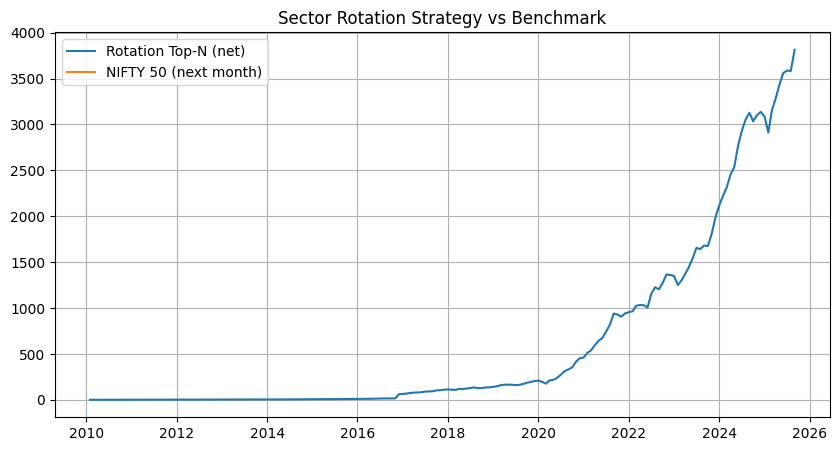

[LOG] Selections rows: 567; Unique months selected: 189
[LOG] Portfolio months: 188

=== Last 12 Months — Top selections ===
                                  Date      Symbol         Price     Ret1M  \
Month                                                                        
2024-10 933  2024-10-31 00:00:00+05:30      ^CNXIT  40407.550781 -0.036679   
        1689 2024-10-31 00:00:00+05:30  ^CNXREALTY    999.549988 -0.090491   
        1500 2024-10-31 00:00:00+05:30  ^CNXPHARMA  22735.550781 -0.023437   
2024-11 934  2024-11-30 00:00:00+05:30      ^CNXIT  43146.250000  0.067777   
        1501 2024-11-30 00:00:00+05:30  ^CNXPHARMA  22240.199219 -0.021788   
        556  2024-11-30 00:00:00+05:30    ^CNXFMCG  57943.699219 -0.021271   
2024-12 557  2024-12-31 00:00:00+05:30    ^CNXFMCG  56799.648438 -0.019744   
        1313 2024-12-31 00:00:00+05:30   ^CNXMETAL   8649.900391 -0.042517   
        935  2024-12-31 00:00:00+05:30      ^CNXIT  43337.800781  0.004440   
2025-01 1881 2025

In [ ]:
# === 7) Monthly Rotation Backtest ===
from dataclasses import dataclass
@dataclass
class BTConfig:
    top_n: int = 3
    tx_cost_bps: float = 5.0  # round-trip cost in basis points (0.05%)
    rebalance: str = 'M'      # monthly

cfg = BTConfig(top_n=3, tx_cost_bps=5.0)

pred = df.copy()
pred['Month'] = pred['Date'].dt.to_period('M')

top_by_month = (
    pred.sort_values(['Date','Proba'], ascending=[True, False])
        .groupby('Month')
        .head(len(SECTORS))
)

def pick_top(group, n):
    return group.nlargest(n, 'Proba')

sel = top_by_month.groupby('Month', group_keys=False).apply(lambda g: pick_top(g, cfg.top_n))

nm_all = sect_ret_m.shift(-1)
nm_ben = bench_ret_m.shift(-1)

def month_return(row):
    d = row['Date']
    sym = row['Symbol']
    try:
        return nm_all.loc[d, sym]
    except KeyError:
        return np.nan

sel['NextRet'] = sel.apply(month_return, axis=1)
port = sel.groupby('Month')['NextRet'].mean().to_timestamp(how='end').dropna()

# Apply transaction costs at each rebalance (approximate once per month)
cost = cfg.tx_cost_bps / 10000.0
port_net = port - cost

# --- Robust alignment between benchmark and portfolio timeline ---
bn = nm_ben.copy()
try:
    if hasattr(bn.index, 'tz') and bn.index.tz is not None:
        bn.index = bn.index.tz_localize(None)
except Exception:
    pass
bench_next = bn.reindex(port_net.index)

def perf_stats(ser):
    ser = ser.dropna()
    if ser.empty:
        return {'CAGR': float('nan'), 'Sharpe': float('nan'), 'MaxDD': float('nan'), 'FinalMultiple': float('nan')}
    rr = (1+ser).cumprod()
    cagr = rr.iloc[-1]**(12/max(len(ser),1)) - 1
    vol = ser.std()*np.sqrt(12)
    sharpe = (ser.mean()/ser.std()*np.sqrt(12)) if ser.std() > 0 else float('nan')
    dd = (rr/rr.cummax()-1).min()
    return {'CAGR': float(cagr), 'Sharpe': float(sharpe), 'MaxDD': float(dd), 'FinalMultiple': float(rr.iloc[-1])}

stats_port = perf_stats(port_net)
stats_bench = perf_stats(bench_next)
print('Portfolio (Top-N) stats:', stats_port)
print('Benchmark (NIFTY50) stats:', stats_bench)

eq_port = (1+port_net.dropna()).cumprod()
eq_bench = (1+bench_next.dropna()).cumprod()

plt.figure()
plt.plot(eq_port.index, eq_port.values, label='Rotation Top-N (net)')
plt.plot(eq_bench.index, eq_bench.values, label='NIFTY 50 (next month)')
plt.title('Sector Rotation Strategy vs Benchmark')
plt.legend()
plt.show()
log(f'Selections rows: {len(sel)}; Unique months selected: {sel["Month"].nunique()}')
log(f'Portfolio months: {len(port_net)}')
print('\n=== Last 12 Months — Top selections ===')
print(sel.groupby('Month').apply(lambda g: g.sort_values('Proba', ascending=False).head(cfg.top_n))
          .tail(cfg.top_n*12))
sel.to_csv('selections.csv', index=False)
pd.DataFrame({'PortNet': port_net}).to_csv('portfolio_returns.csv')
pd.DataFrame({'BenchNext': bench_next}).to_csv('benchmark_returns.csv')
log('Saved selections.csv, portfolio_returns.csv, benchmark_returns.csv')
print('\n=== Stats ===')
print('Portfolio (Top-N):', stats_port)
print('Benchmark:', stats_bench)


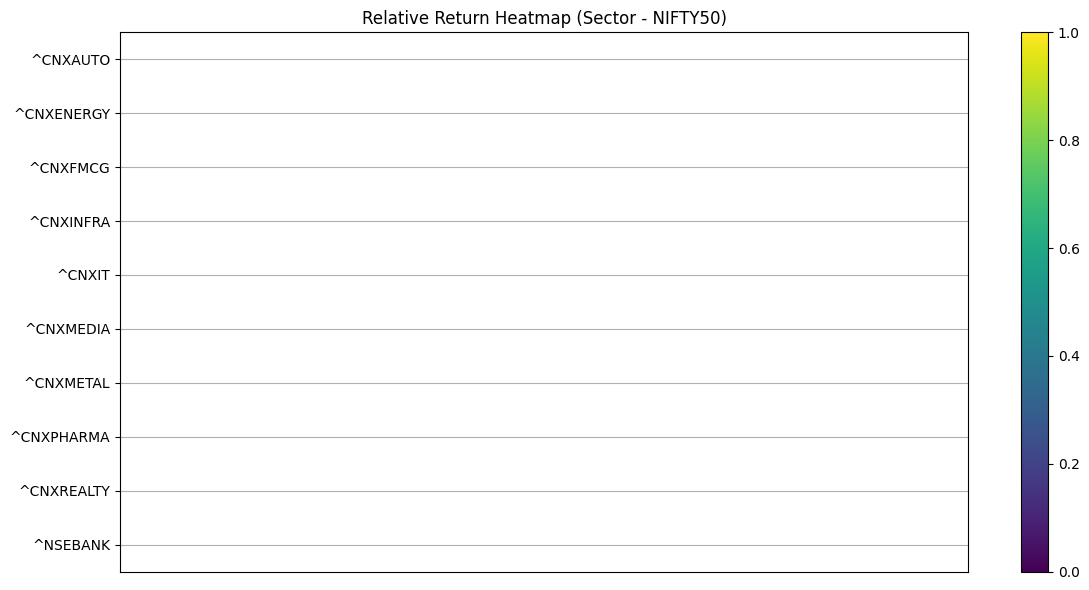

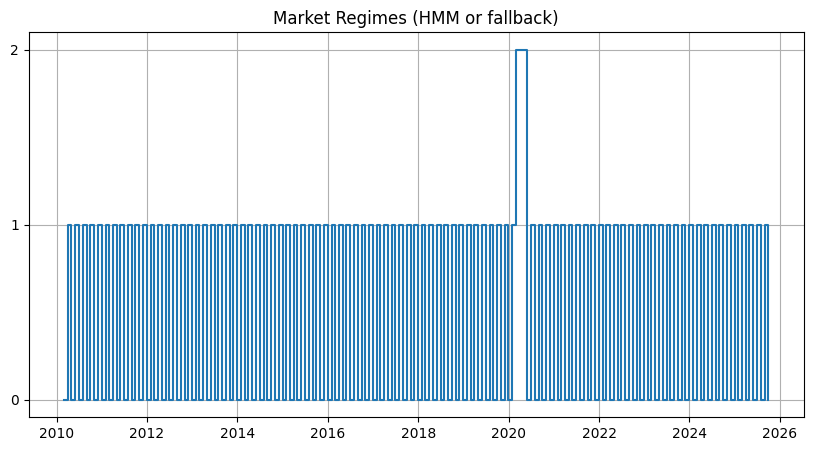

In [ ]:
# === 8) Diagnostics & Visuals ===
# Heatmap of relative returns (sector - benchmark)
rel = rel_ret.copy()
rel = rel.loc[rel.index.intersection(port_net.index)]

plt.figure(figsize=(12,6))
plt.imshow(rel.T, aspect='auto', interpolation='nearest')
plt.yticks(range(len(rel.columns)), rel.columns)
plt.xticks(range(len(rel.index)), [d.strftime('%Y-%m') for d in rel.index], rotation=90)
plt.title('Relative Return Heatmap (Sector - NIFTY50)')
plt.colorbar()
plt.tight_layout()
plt.show()

# Regime timeline plot
plt.figure()
plt.plot(bench_df['Date'], bench_df['Regime'], drawstyle='steps-post')
plt.yticks(sorted(bench_df['Regime'].unique()))
plt.title('Market Regimes (HMM or fallback)')
plt.show()


## Next Steps / Extensions
- Add **macro features**: CPI, WPI, USDINR, Brent, G-Sec yields, PMI.
- Swap **monthly** to **weekly** or **biweekly** rebalance to react faster.
- Add **risk controls**: max sector weight, vol targeting, regime-aware top-N.
- Replace Yahoo indices with **sector ETFs** if you prefer tradability.
- Try **Reinforcement Learning** for dynamic allocation across sectors.
- Log and compare **feature importances** across regimes.


### References (tickers & index pages)
- Yahoo Finance: NIFTY IT (^CNXIT), NIFTY BANK (^NSEBANK), NIFTY AUTO (^CNXAUTO), NIFTY PHARMA (^CNXPHARMA), NIFTY FMCG (^CNXFMCG), NIFTY METAL (^CNXMETAL), NIFTY ENERGY (^CNXENERGY), NIFTY REALTY (^CNXREALTY), NIFTY MEDIA (^CNXMEDIA), NIFTY INFRA (^CNXINFRA), NIFTY 50 (^NSEI)
- Official index descriptions: niftyindices.com


In [ ]:
print('✅ Pipeline completed. If charts are not visible, ensure %matplotlib inline is active (top cell).')
print('Files saved: df_preview.csv, selections.csv, portfolio_returns.csv, benchmark_returns.csv')


✅ Pipeline completed. If charts are not visible, ensure %matplotlib inline is active (top cell).
Files saved: df_preview.csv, selections.csv, portfolio_returns.csv, benchmark_returns.csv
